<h2>Imports</h2>

In [1]:
import math
import random
import time
import pdb
import numpy as np
import os
from typing import Tuple, List
from collections import OrderedDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import networkx as nx
import dgl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pl_bolts.datamodules import ExperienceSourceDataset
from pl_bolts.datamodules.experience_source import Experience

from policies.pytorch_custom_lstm import LayerNormLSTMCell

Using backend: pytorch
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/jit/_recursive.py:165: UserWarning: 'layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [16]:
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.cmd_util import make_vec_env

from envs.Collins2018 import Collins2018Task

num_envs = 5
envs = make_vec_env(lambda: Collins2018Task(num_objects=(3, 4, 5, 6),
                                            num_actions=6,
                                            num_repeats=6,
                                            max_observations=6,
                                            mode='permutation'
                                           ),
                    n_envs=num_envs)


<h2>Neural Network</h2>

In [5]:
class A2C_LSTM(pl.LightningModule):
    """Container Module with a LSTM layer leading to an action and value network module."""
    
    def __init__(self, num_inputs, num_outputs, num_LSTM):
        super().__init__()
        self.rnn = LayerNormLSTMCell(num_inputs, num_LSTM)
        self.actor = nn.Sequential(
            nn.Linear(num_LSTM, num_outputs),
            nn.LogSoftmax(dim=-1)
        )
        self.critic = nn.Linear(num_LSTM, 1)
        
        self.num_LSTM = num_LSTM
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.init_weights()
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        value = self.critic(output)
        action_log_prob = self.actor(output)
        action_prob = Categorical(logits=action_log_prob)
        return action_prob, value, hidden
        
    def init_weights(self):
        init_scale = 1.4
        self.rnn.layernorm_i.weight.data.uniform_(-init_scale, init_scale)
        self.rnn.layernorm_i.bias.data.zero_()
        self.rnn.layernorm_h.weight.data.uniform_(-init_scale, init_scale)
        self.rnn.layernorm_h.bias.data.zero_()
        self.rnn.layernorm_c.weight.data.uniform_(-init_scale, init_scale)
        self.rnn.layernorm_c.bias.data.zero_()
        self.actor[0].weight.data.uniform_(-init_scale, init_scale)
        self.actor[0].bias.data.zero_()
        self.critic.weight.data.uniform_(-init_scale, init_scale)
        self.critic.bias.data.zero_()
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (
            weight.new_zeros(batch_size, self.num_LSTM),
            weight.new_zeros(batch_size, self.num_LSTM)
        )

In [61]:
class A2C_LSTM_System(pl.LightningModule):

    def __init__(
        self,
        envs,
        num_LSTM: int = 20,
        lr: float = 7e-4,
        gamma: float = 0.9,
        value_loss_coef: float = 0.05,
        entropy_coef: float = 0.05,
        num_steps: int = 20,
        num_batch_episodes: int = 1,
        avg_reward_len: int = 5
    ):
        super().__init__()
        
        self.envs = envs
        self.num_envs, self.num_inputs = self.envs.reset().shape
        self.num_outputs = envs.get_attr("num_actions")[0]
        self.num_LSTM = num_LSTM
        self.net = A2C_LSTM(self.num_inputs, self.num_outputs, self.num_LSTM)
        
        # Hyperparameters
        self.lr = lr
        self.entropy_coef = entropy_coef
        self.gamma = gamma
        self.num_steps = num_steps
        self.num_batch_episodes = num_batch_episodes

        self.save_hyperparameters()
        
        # Tracking metrics
        self.total_steps = 0
        self.total_rewards = [0]
        self.done_episodes = 0
        self.avg_rewards = 0
        self.reward_sum = 0.0
        self.batch_episodes = 0
        self.avg_reward_len = avg_reward_len

        self.batch_states = []
        self.batch_hidden_states = []
        self.batch_actions = []
        self.batch_log_probs = []
        self.batch_entropy = []
        self.batch_values = []
        self.batch_rewards = []
        self.batch_masks = []
        
        self.init_weights()

    def init_weights(self):
        self.net.init_weights()
       
    def init_hidden(self, batch_size):
        return self.net.init_hidden(batch_size)
    
    def reset_hidden(self, hidden):
        for h in hidden:
            h.detach()
    
    def forward(self, x, hidden):
        return self.net(x, hidden)
        
    def training_step(self, batch, batch_idx):
        #optimizer = self.optimizers(use_pl_optimizer=True)
        #optimizer.zero_grad()
        states, hidden_states, log_probs, values, returns, masks, entropy = batch

        loss = self.loss(states, hidden_states, log_probs, entropy, values, returns)
        print(log_probs)
        print('at training step')
        #self.manual_backward(loss, optimizer)
        #pdb.set_trace()
        print('finished BPTT')
        #optimizer.step()
        #pdb.set_trace()
        log = {
            "episodes": self.done_episodes,
            "reward": self.total_rewards[-1],
            "avg_reward": self.avg_rewards,
        }

        return OrderedDict({
            "loss": loss,
            "avg_reward": self.avg_rewards,
            "log": log,
            "progress_bar": log,
        })
        return loss

    def train_batch(self) -> Tuple[List[torch.Tensor], List[torch.Tensor],\
                                   List[torch.Tensor], List[torch.Tensor],\
                                   List[torch.Tensor], List[torch.Tensor]]:
    
        state = torch.Tensor(self.envs.reset())
        hidden = self.init_hidden(self.num_envs)
        print('start of train_batch')

        while True:
            dist, value, next_hidden = self(state, hidden)
            action = dist.sample()
            next_state, reward, done, _ = self.envs.step(action.cpu().numpy())

            self.batch_states.append(state)
            #self.batch_hidden_states.append(hidden)
            self.batch_hidden_states.append(0)
            self.batch_rewards.append(reward)
            self.batch_actions.append(action)
            self.batch_log_probs.append(dist.log_prob(action))
            self.batch_entropy.append(dist.entropy())
            self.batch_values.append(value)
            self.batch_masks.append(1-done)
            state, hidden = torch.Tensor(next_state), next_hidden
            self.total_steps += 1
            
            if any(done):
                #self.batch_episodes += 1
                #self.done_episodes += 1
                #self.total_rewards.append(np.stack(self.batch_rewards).sum())
                #self.avg_rewards = float(np.mean(self.total_rewards[-self.avg_reward_len:]))
                
            #if self.batch_episodes >= self.num_batch_episodes:  # right now only returns after each episode
                returns = self.compute_returns(self.batch_rewards, self.batch_masks)
                yield self.batch_states,\
                        self.batch_hidden_states,\
                        self.batch_log_probs,\
                        self.batch_values,\
                        returns,\
                        self.batch_masks,\
                        self.batch_entropy
            
                #self.batch_states.clear()
                #self.batch_hidden_states.clear()
                #self.batch_actions.clear()
                #self.batch_log_probs.clear()
                #self.batch_values.clear()
                #self.batch_rewards.clear()
                #self.batch_masks.clear()
                self.batch_states = []
                self.batch_hidden_states = []
                self.batch_actions = []
                self.batch_log_probs = []
                self.batch_values = []
                self.batch_rewards = []
                self.batch_masks = []
                
                self.reset_hidden(hidden)
                self.state = torch.Tensor(self.envs.reset())
                

    def loss(self, states, hidden_states, log_probs, entropy, values, returns) -> torch.Tensor:
        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values).squeeze(-1)
        entropy   = torch.cat(entropy).mean()

        advantage   = returns - values
        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        #print(advantage)
        #loss = actor_loss + 0.05 * critic_loss - 0.05 * entropy
        loss = entropy
        return loss

    def compute_returns(self, rewards, masks):
        R = 0
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.append(R)
        return returns[::-1]
    
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.net.parameters(), lr=self.lr)
        return optimizer
    
    def _dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = ExperienceSourceDataset(self.train_batch)
        dataloader = DataLoader(dataset=dataset, batch_size=1)
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self._dataloader()
    
    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch"""
        return batch[0][0][0].device.index if self.on_gpu else "cpu"

In [62]:
test_system = A2C_LSTM_System(envs)
# save checkpoints based on avg_reward
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="avg_reward", mode="max", period=1, verbose=True)
seed_everything(123)
trainer = pl.Trainer()
trainer.fit(test_system)

Global seed set to 123
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name | Type     | Params
----------------------------------
0 | net  | A2C_LSTM | 2.3 K 
----------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params


start of train_batch
[tensor([[-2.3496, -3.1155]], grad_fn=<StackBackward>), tensor([[-0.2780, -0.4852]], grad_fn=<StackBackward>), tensor([[-1.7767, -0.5954]], grad_fn=<StackBackward>), tensor([[-1.0231, -0.6375]], grad_fn=<StackBackward>), tensor([[-1.4080, -0.6947]], grad_fn=<StackBackward>), tensor([[-0.4312, -1.2437]], grad_fn=<StackBackward>), tensor([[-1.3595, -0.6275]], grad_fn=<StackBackward>), tensor([[-0.1967, -0.6817]], grad_fn=<StackBackward>), tensor([[-0.9402, -1.3000]], grad_fn=<StackBackward>), tensor([[-0.2668, -0.9838]], grad_fn=<StackBackward>), tensor([[-0.9476, -0.5001]], grad_fn=<StackBackward>), tensor([[-0.2791, -0.7827]], grad_fn=<StackBackward>), tensor([[-0.7784, -0.7788]], grad_fn=<StackBackward>), tensor([[-0.2712, -2.1448]], grad_fn=<StackBackward>), tensor([[-0.8161, -1.4934]], grad_fn=<StackBackward>), tensor([[-0.3288, -2.8070]], grad_fn=<StackBackward>), tensor([[-0.7635, -1.3512]], grad_fn=<StackBackward>), tensor([[-0.4458, -0.4841]], grad_fn=<Stack

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 3]], which is output 0 of TBackward, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


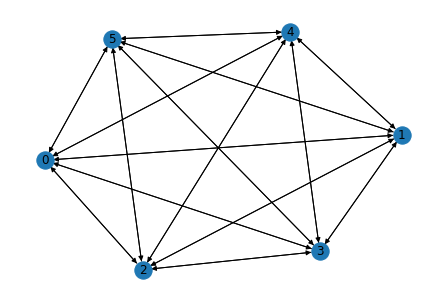

In [17]:
# draw a graph with N nodes
def make_clique(num_nodes, draw_graph=False):
    """Create a Clique with num_nodes nodes."""
    u, v = [], []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j: continue
            u.append(i)
            v.append(j)

    g = dgl.DGLGraph((u, v))
    if draw_graph: nx.draw(g.to_networkx(), with_labels=True)
    return g

gg = make_clique(6, True)

In [26]:
class GRNLayer(nn.Module):
    def __init__(self, g, num_inputs, num_hidden):
        super().__init__()
        self.w_i = nn.Linear(num_inputs, num_hidden, bias=False)
        self.attn_i = nn.Linear(2*num_hidden, 1, bias=False)
        self.w_h = nn.Linear(2*num_hidden, num_hidden, bias=False)
        self.attn_h = nn.Linear(2*num_hidden, 1, bias=False)
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.g = g
        self.reset_parameters()
        
    def reset_parameters(self):
        """Reset learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.w_i.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_i.weight, gain=gain)
        nn.init.xavier_normal_(self.w_h.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_h.weight, gain=gain)
    
    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=2)
        a_h = self.attn_h(z2)
        return {'e': F.leaky_relu(a_h)}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        a_h = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(a_h * nodes.mailbox['z'], dim=1)
        return {'h': h}
        
    def forward(self, state, hidden):
        pdb.set_trace()
        
        z_i = self.w_i(state)
        a_i = F.softmax(torch.matmul(hidden, z_i.unsqueeze_(2)), dim=1)
        # ger is deprecated outer product function, should be torch.outer in the future
        h_i = torch.cat([torch.ger(a_i[b, :, 0], z_i[b, :, 0]).unsqueeze_(0) for b in range(hidden.size(0))], 0)
        pdb.set_trace()
        h_concat = torch.cat([hidden, h_i], dim=2)
        
        z = self.w_h(h_concat)
        # a very basic model with no GNN 
        return z


        #self.g.ndata['z'] = z.transpose_(0, 1)  # change to (num_nodes, batch_size)
        #self.g.apply_edges(self.edge_attention)
        #self.g.update_all(self.message_func, self.reduce_func)
        #return self.g.ndata.pop('h').transpose_(0, 1)  # change to (batch_size, num_nodes)


In [27]:
class MultiHeadGRNLayer(nn.Module):
    def __init__(self, g, num_inputs, num_hidden, num_heads, merge='cat'):
        super().__init__()
        self.g = g
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GRNLayer(g, num_inputs, num_hidden))
        self.merge = merge
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_heads = num_heads

    def forward(self, state, hidden):
        h_split = torch.split(hidden, num_hidden, dim=2)
        head_outs = [attn_head(state, h) for attn_head, h in zip(self.heads, h_split)]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=2)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [28]:
class A2C_GRN(nn.Module):
    def __init__(self, g, num_inputs, num_outputs, num_hidden, num_heads, num_iterations):
        super().__init__()
        self.g = g
        self.layer = MultiHeadGRNLayer(g, num_inputs, num_hidden, num_heads)
        self.actor = nn.Sequential(
            nn.Linear(num_hidden * num_heads * g.number_of_nodes(), num_outputs),
            nn.LogSoftmax(dim=-1)
        )
        self.critic = nn.Linear(num_hidden * num_heads * g.number_of_nodes(), 1)
        self.num_iterations = num_iterations
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        
    def init_weights(self):
        self.layer.reset_parameters()
        init_scale = 1.4
        self.actor[0].weight.data.uniform_(-init_scale, init_scale)
        self.actor[0].bias.data.zero_()
        self.critic.weight.data.uniform_(-init_scale, init_scale)
        self.critic.bias.data.zero_()
        
    def init_hidden(self, batch_size):
        hidden = torch.randn(batch_size, self.g.number_of_nodes(), self.num_hidden * self.num_heads)
        return nn.init.normal_(hidden)
        
    
    def forward(self, state, hidden):
        for it in range(self.num_iterations):
            hidden = self.layer(state, hidden)
        value = self.critic(torch.reshape(hidden, (hidden.size(0), -1)))
        action_log_prob = self.actor(torch.reshape(hidden, (hidden.size(0), -1)))
        action_prob = Categorical(logits=action_log_prob)
        return action_prob, value, hidden
    
    


In [ ]:
# testing my code

num_inputs = 3
num_outputs = 3  # num_actions
num_hidden = 5
num_nodes = 7
num_heads = 3
num_iteration = 5
state = torch.FloatTensor([1, 1, 1]).to(device)
hidden = torch.randn(num_nodes, num_hidden * num_heads)

g = make_clique(num_nodes)

#model = GRNLayer(g, num_inputs, num_hidden)
#hidden_out = model(state, hidden)
#print(hidden_out.size())

#model2 = MultiHeadGRNLayer(g, num_inputs, num_hidden, num_heads)
#hidden_out2 = model2(state, hidden)
#print(hidden_out2.size())

#model3 = A2C_GRN(g, num_inputs, num_outputs, num_hidden, num_heads, num_iteration)
#hidden = model3.init_hidden(2)
#print(hidden.size())
#prob, value, hi = model3(state, hidden)
#print(prob)
#print(value)
#print(hi.size())

In [21]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = envs.reset()
    if vis: envs.render()
    done = [False] * envs.num_envs
    total_reward = 0
    hidden = model.init_hidden(envs.num_envs)
    
    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, _, hidden = model(state, hidden)
        
        next_state, reward, done, _ = envs.step(dist.sample().cpu().numpy())
        state = next_state
        if vis: envs.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [22]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [8]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
num_LSTM    = 20
lr          = 7e-4
num_steps   = 5
batch_size  = 1

model_LSTM = A2C_LSTM(num_inputs, num_outputs, num_LSTM).to(device)
optimizer = optim.RMSprop(model_LSTM.parameters(), lr=lr)

In [29]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n
num_hidden = 40
num_nodes = 6
num_heads = 3
num_iterations = 1
lr = 7e-4
num_steps = 5

g = make_clique(num_nodes)
model_GRN = A2C_GRN(g, num_inputs, num_outputs, num_hidden, num_heads, num_iterations).to(device)
optimizer = optim.RMSprop(model_GRN.parameters(), lr=lr)

In [30]:
max_frames   = 20_000_000
frame_idx    = 0
test_rewards = []

In [31]:
t_record = time.time()
model = model_GRN
while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = []
    
    done = [False] * num_envs
    state = envs.reset()
    hidden = model.init_hidden(num_envs)

    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, value, hidden = model(state, hidden)
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(1)
        
        entropy.append(dist.entropy().unsqueeze(1))
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 10000 == 0:
            test_reward = np.mean([test_env() for _ in range(3)])
            test_rewards.append(test_reward)
            print(f'at frame {int(frame_idx)},\t mean testing reward {test_reward :.2f}')
            
        if frame_idx % 10000 == 0:
            plot(frame_idx, test_rewards)
            #print(f'at frame {int(frame_idx)},\t takes time {(time.time() - t_record) :.2f} seconds')

    returns = compute_returns(torch.zeros(envs.num_envs, 1), rewards, masks, gamma=0.9)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)
    entropy = torch.cat(entropy).mean()
    
    
    advantage = returns - values
    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    loss = actor_loss + 0.05 * critic_loss - 0.05 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

> <ipython-input-26-0ac0f61c65e2>(38)forward()
-> z_i = self.w_i(state)
(Pdb) c
> <ipython-input-26-0ac0f61c65e2>(43)forward()
-> h_concat = torch.cat([hidden, h_i], dim=2)
(Pdb) h_i.shape
torch.Size([5, 6, 40])
(Pdb) q


BdbQuit: 

In [14]:
# LSTM: at 2M trials, testing reward is 10 +- 4.55
# front end of GRN: at 3M trials, 8.1 +- 2.7
# front end of GRN, task(3, 4, 5, 6): at 10M trials, 7.95 +- 3
testing_rewards = [test_env() for _ in range(20)]
print(np.mean(testing_rewards), np.std(testing_rewards))

7.95 3.0963688


In [ ]:
a_i = F.softmax(torch.matmul(hidden, z_i.unsqueeze_(2)), dim=1)
        # ger is deprecated outer product function, should be torch.outer in the future
        h_i = torch.cat([torch.ger(a_i[b, :, 0], z_i[b, :, 0]).unsqueeze_(0) for b in range(hidden.size(0))], 0)
        h_concat = torch.cat([hidden, h_i], dim=2)
        
        z = self.w_h(h_concat)